In [42]:
import pandas as pd
import os
import glob
import requests
from datetime import datetime
import matplotlib.pyplot as plt

In [13]:
rtd_loc = r"..\data\readthedocs"
pypi_loc = r"..\data\pypistats"

files = glob.glob(os.path.join(rtd_loc, "readthedocs_traffic_analytics_openpolicedata_*.csv"))

csvs = []
for f in files:
    csvs.append(pd.read_csv(f).sort_values(by="Date"))


df = pd.concat(csvs, ignore_index=True)
df = df.drop_duplicates(subset=["Date","Version","Path"], keep='last').sort_values(by="Date", ignore_index=True)
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")
df = df[df['Version']=='stable']
df.head()

,Version,Path,Views
Date,,,
2023-09-17,stable,/index.html,5
2023-09-18,stable,/documentation.html,2
2023-09-18,stable,/index.html,8
2023-09-19,stable,/resources/index.html,1
2023-09-19,stable,/index.html,3


In [27]:
df_index = df[df['Path']=='/index.html'].copy()
df_index = df_index.resample("1D").sum()
df_index['Views Filtered'] = df_index['Views'].rolling(window='7D', center=True).mean()
df_index.head()

,Version,Path,Views,Views Filtered
Date,,,,
2023-09-17,stable,/index.html,5,4.250000
2023-09-18,stable,/index.html,8,3.400000
2023-09-19,stable,/index.html,3,2.833333
2023-09-20,stable,/index.html,1,2.428571
2023-09-21,0,0,0,1.857143


<Axes: xlabel='Date'>

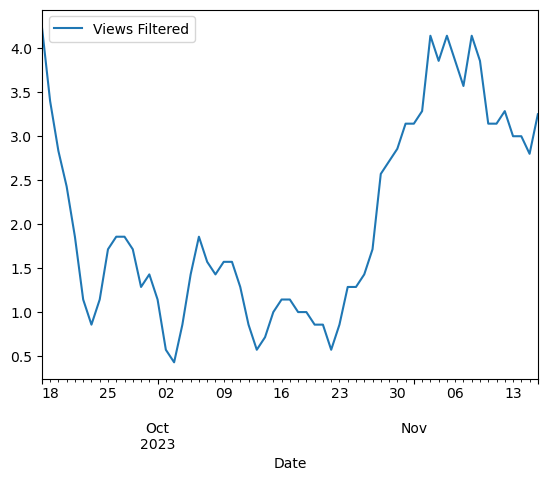

In [29]:
df_index.plot.line(y="Views Filtered")

In [64]:
# Update pypi stats
pypi = 'https://pypistats.org/api/'
r = requests.get(pypi+"packages/openpolicedata/overall", params={'mirrors':False})
r.raise_for_status()
data = r.json()

pypi_df = pd.DataFrame(data['data'])
filename = os.path.join(pypi_loc, "pypistats_"+ datetime.now().strftime("%Y%m%d")+".csv")
if not os.path.exists(filename):
    pypi_df.to_csv(filename, index=False)

In [39]:
files = glob.glob(os.path.join(pypi_loc, "pypistats_*.csv"))

csvs = []
for f in files:
    csvs.append(pd.read_csv(f).sort_values(by="date"))

df_pypi = pd.concat(csvs, ignore_index=True)
df_pypi["date"] = pd.to_datetime(df_pypi["date"])
df_pypi = df_pypi[df_pypi['date']>df.index.min()]
df_pypi=df_pypi[df_pypi['category']=='without_mirrors']
df_pypi = df_pypi.drop_duplicates(subset=["date"], keep='last').sort_values(by="date", ignore_index=True)
df_pypi = df_pypi.set_index('date')
df_pypi = df_pypi.resample("1D").sum()
df_pypi['Downloads Filtered'] = df_pypi['downloads'].rolling(window='7D', center=True).mean()
df_pypi.tail(5)

,category,downloads,Downloads Filtered
date,,,
2023-11-11,0,0,3.142857
2023-11-12,0,0,2.857143
2023-11-13,without_mirrors,3,2.666667
2023-11-14,without_mirrors,10,2.800000
2023-11-15,without_mirrors,1,3.500000


<Axes: xlabel='date'>

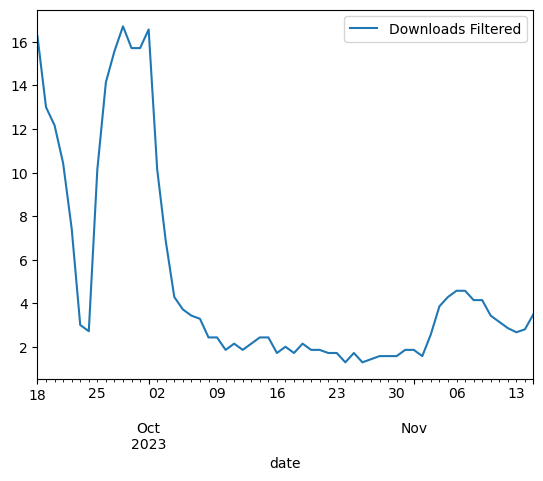

In [41]:
df_pypi.plot.line(y="Downloads Filtered")

<Axes: xlabel='date'>

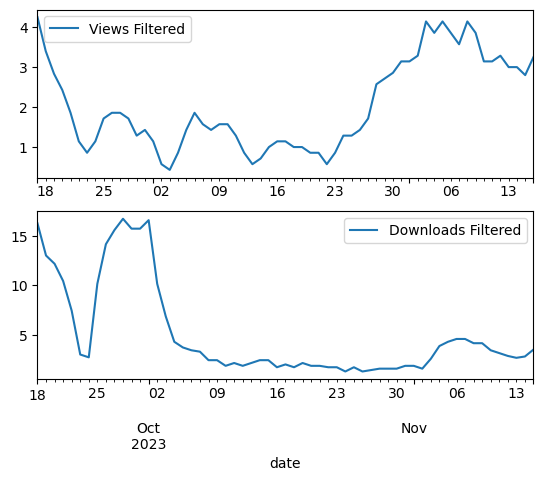

In [47]:
fig, axes = plt.subplots(nrows=2, ncols=1)

df_index.plot.line(y="Views Filtered", ax=axes[0])
df_pypi.plot.line(y="Downloads Filtered", ax=axes[1])